<a href="https://colab.research.google.com/github/AmoghKhaparde/SocialMediaSentimentAnalysis/blob/main/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install snscrape
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
import optuna
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import re
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

Mounted at /content/drive


In [ ]:
# Load and preprocess the dataset
class AmazonReviewDataset(Dataset):
    def __init__(self, reviews, sentiments, vocab, max_len=64):
        self.reviews = reviews
        self.sentiments = sentiments
        self.max_len = max_len
        self.vocab = vocab
        self.reviews = [self.tokenize_review(review) for review in self.reviews]
        self.sentiments = [sentiment - 1 for sentiment in self.sentiments]  # Map 1-5 to 0-4 for PyTorch compatibility

    def tokenize_review(self, review):
        if isinstance(review, str):  # Ensure the review is a string
            review = review.lower()
            review = re.sub(r'[^a-z0-9\s]', '', review)
            tokens = review.split()
            token_indices = [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]
            if len(token_indices) < self.max_len:
                token_indices += [self.vocab['<PAD>']] * (self.max_len - len(token_indices))
            return token_indices[:self.max_len]
        else:
            return [self.vocab['<PAD>']] * self.max_len  # Return a padded sequence if the review is not a string

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = torch.tensor(self.reviews[idx], dtype=torch.long)
        sentiment = torch.tensor(self.sentiments[idx], dtype=torch.long)
        return review, sentiment

In [ ]:
# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-np.log(10000.0) / embed_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

In [ ]:
# Custom Transformer Encoder Layer
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_size, num_heads, feedforward_dim, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(embed_size, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, embed_size)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, src_mask=None):
        attn_output, _ = self.self_attn(x, x, x, attn_mask=src_mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        return self.norm2(x + self.dropout(ff_output))

In [ ]:
# Full Transformer Encoder Model
class TransformerSentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size=64, num_heads=4, feedforward_dim=256, num_layers=4, num_classes=5, max_len=64):
        super(TransformerSentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size, max_len)
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(embed_size, num_heads, feedforward_dim) for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(0.3)
        self.fc_out = nn.Linear(embed_size, num_classes)

    def forward(self, x, src_mask=None):
        x = self.embedding(x) * np.sqrt(x.size(-1))
        x = self.positional_encoding(x)
        for layer in self.encoder_layers:
            x = layer(x, src_mask)
        x = torch.mean(x, dim=1)  # Global average pooling
        x = self.dropout(x)
        return self.fc_out(x)

In [ ]:
# Build the vocabulary
def build_vocab(reviews, max_vocab_size=10000):
    freq_dict = {}
    for review in reviews:
        if isinstance(review, str):  # Ensure the review is a string
            review = re.sub(r'[^a-z0-9\s]', '', review.lower())
            for word in review.split():
                if word in freq_dict:
                    freq_dict[word] += 1
                else:
                    freq_dict[word] = 1
    sorted_vocab = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)
    vocab = {word: idx + 2 for idx, (word, _) in enumerate(sorted_vocab[:max_vocab_size])}
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    return vocab

In [ ]:
# Load the dataset and prepare data
csv_file = 'drive/MyDrive/AmazonReview.csv'
raw_data = pd.read_csv(csv_file)
raw_data.dropna(subset=['Review'], inplace=True)  # Drop rows with missing reviews

# Build vocabulary
vocab = build_vocab(raw_data['Review'].tolist())

# Stratified split using train_test_split
train_data, temp_data, train_labels, temp_labels = train_test_split(
    raw_data['Review'], raw_data['Sentiment'], test_size=0.2, stratify=raw_data['Sentiment'], random_state=42
)

val_data, test_data, val_labels, test_labels = train_test_split(
    temp_data, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Convert Series to lists for Dataset class
train_dataset = AmazonReviewDataset(train_data.tolist(), train_labels.tolist(), vocab)
val_dataset = AmazonReviewDataset(val_data.tolist(), val_labels.tolist(), vocab)
test_dataset = AmazonReviewDataset(test_data.tolist(), test_labels.tolist(), vocab)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Initialize model parameters with reduced values
# vocab_size = len(vocab)
# embed_size = 128
# num_heads = 8
# feedforward_dim = 128
# num_layers = 2
# max_len = 64

vocab_size = len(vocab)
embed_size = 64
num_heads = 2
feedforward_dim = 256
num_layers = 2
max_len = 64

In [ ]:
# Instantiate the model
model = TransformerSentimentClassifier(
    vocab_size=vocab_size,
    embed_size=embed_size,
    num_heads=num_heads,
    feedforward_dim=feedforward_dim,
    num_layers=num_layers,
    num_classes=5,
    max_len=max_len
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss().to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.0004537732705061167)
optimizer = optim.Adam(model.parameters(), lr=0.00009777761436674669)

In [ ]:
# Training and evaluation functions
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    correct_preds = 0
    total_samples = 0

    for reviews, sentiments in data_loader:
        reviews = reviews.to(device)
        sentiments = sentiments.to(device)

        optimizer.zero_grad()
        outputs = model(reviews)
        loss = loss_fn(outputs, sentiments)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        correct_preds += torch.sum(preds == sentiments).item()
        total_samples += len(sentiments)

    avg_loss = total_loss / len(data_loader)
    avg_accuracy = correct_preds / total_samples
    return avg_loss, avg_accuracy

def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct_preds = 0
    total_samples = 0

    with torch.no_grad():
        for reviews, sentiments in data_loader:
            reviews = reviews.to(device)
            sentiments = sentiments.to(device)

            outputs = model(reviews)
            loss = loss_fn(outputs, sentiments)
            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            correct_preds += torch.sum(preds == sentiments).item()
            total_samples += len(sentiments)

    avg_loss = total_loss / len(data_loader)
    avg_accuracy = correct_preds / total_samples
    return avg_loss, avg_accuracy

In [ ]:
# Training and evaluation tracking
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
epochs = 30
for epoch in range(epochs):
    train_loss, train_accuracy = train_epoch(model, train_loader, loss_fn, optimizer, device)
    val_loss, val_accuracy = eval_model(model, val_loader, loss_fn, device)

    # Track losses and accuracies
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Save the model
torch.save(model.state_dict(), 'transformer_sentiment_model.pth')

Epoch 1/30
Train Loss: 1.6072, Train Accuracy: 0.2311
Val Loss: 1.5935, Val Accuracy: 0.2356
Epoch 2/30
Train Loss: 1.5835, Train Accuracy: 0.2603
Val Loss: 1.5735, Val Accuracy: 0.2968
Epoch 3/30
Train Loss: 1.5542, Train Accuracy: 0.3032
Val Loss: 1.5365, Val Accuracy: 0.3256
Epoch 4/30
Train Loss: 1.5211, Train Accuracy: 0.3281
Val Loss: 1.5002, Val Accuracy: 0.3364
Epoch 5/30
Train Loss: 1.4842, Train Accuracy: 0.3508
Val Loss: 1.4638, Val Accuracy: 0.3748
Epoch 6/30
Train Loss: 1.4555, Train Accuracy: 0.3655
Val Loss: 1.4403, Val Accuracy: 0.3776
Epoch 7/30
Train Loss: 1.4307, Train Accuracy: 0.3780
Val Loss: 1.4227, Val Accuracy: 0.3836
Epoch 8/30
Train Loss: 1.4092, Train Accuracy: 0.3867
Val Loss: 1.4111, Val Accuracy: 0.3784
Epoch 9/30
Train Loss: 1.3928, Train Accuracy: 0.3930
Val Loss: 1.3968, Val Accuracy: 0.3932
Epoch 10/30
Train Loss: 1.3768, Train Accuracy: 0.4023
Val Loss: 1.3817, Val Accuracy: 0.4056
Epoch 11/30
Train Loss: 1.3617, Train Accuracy: 0.4106
Val Loss: 1.36

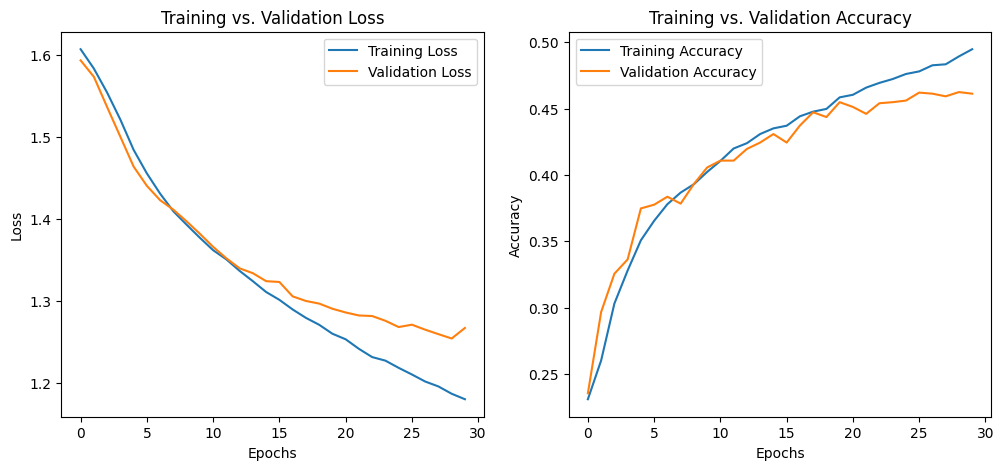

In [ ]:
# Plotting loss and accuracy curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()

plt.show()

Test Loss: 1.2894, Test Accuracy: 0.4556
              precision    recall  f1-score   support

           1       0.59      0.55      0.57       500
           2       0.38      0.31      0.34       500
           3       0.35      0.34      0.35       500
           4       0.41      0.43      0.42       500
           5       0.53      0.64      0.58       500

    accuracy                           0.46      2500
   macro avg       0.45      0.46      0.45      2500
weighted avg       0.45      0.46      0.45      2500



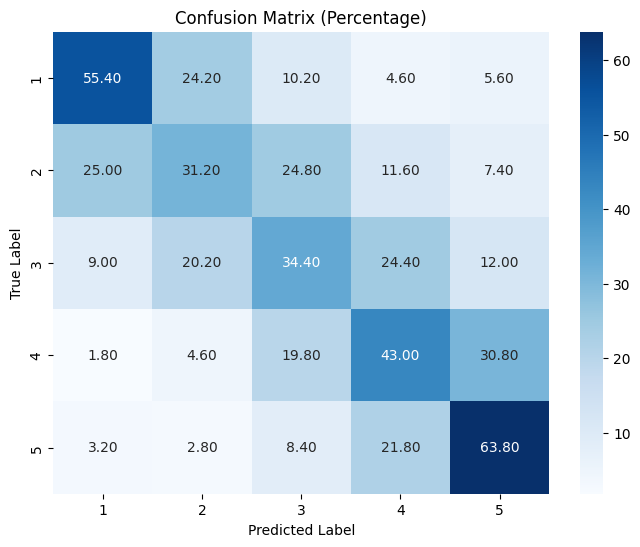

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming 'model', 'vocab', and other relevant components are already defined

def get_true_and_predicted_labels(data_loader, model, vocab, device):
    true_labels = []
    predicted_labels = []

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for comments, sentiments in data_loader:
            comments = comments.to(device)
            sentiments = sentiments.to(device)

            # Predict
            outputs = model(comments)
            _, preds = torch.max(outputs, dim=1)

            true_labels.extend(sentiments.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    return np.array(true_labels), np.array(predicted_labels)

# Plot confusion matrix with percentages
def plot_confusion_matrix_percent(true_labels, predicted_labels, classes):
    cm = confusion_matrix(true_labels, predicted_labels)

    # Normalize the confusion matrix to show percentages
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix (Percentage)')
    plt.show()

# Assuming test_loader contains test data (comments and true sentiments)
def evaluate_confusion_matrix_percent(data_loader):
    true_labels, predicted_labels = get_true_and_predicted_labels(data_loader, model, vocab, device)

    # List of classes (1 to 5 for sentiments)
    classes = [1, 2, 3, 4, 5]

    # Print the classification report
    print(classification_report(true_labels, predicted_labels, target_names=[str(cls) for cls in classes]))

    # Plot the confusion matrix with percentages
    plot_confusion_matrix_percent(true_labels, predicted_labels, classes)

# Assuming you have a DataLoader (e.g., `test_loader`) with your test set

test_loss, test_accuracy = eval_model(model, test_loader, loss_fn, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

evaluate_confusion_matrix_percent(test_loader)

<ipython-input-32-2e619c643e2f>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('transformer_sentiment_model.pth', map_location=torch.devi

The only interesting thing will be iphone se 4 if it comes with a good upgrade , everything else is just gimmicks
4


They’ll release the iPhone 17 next year. It’s better than iPhone 16. “aRe yOu eXcItEd”
3


I am hoping to see some iPhone 16 pro max exclusive Apple Intelligence features.
3


can't wait!
1


I expect giveaway
5


With my Apple Watch battery health on 66%. I don't have a choice to excited on Apple Watch 10.
5


Couldn’t care less.
1


Apple Intelligence , AI for short
5


Very excited. I’m aiming to get the iPhone 16 pro max this time. 256 gb
1


Hey, I'm using Telegram to chat. Join me! Download it here:
5


AirPods Pro 3 please
5


a little
5


S10 is coming, can't wait to change my S6
3


I thought they would say sth about the SE 4th gen
3


Everyone tomorrow
5


For the air pods 4 sure, but I wouldn’t be buying mine yet as I still have a perfectly great pair of air pods 3rd generation.
4


Still waiting for apple to bang a 10x optical zoom periscope camera in a phon

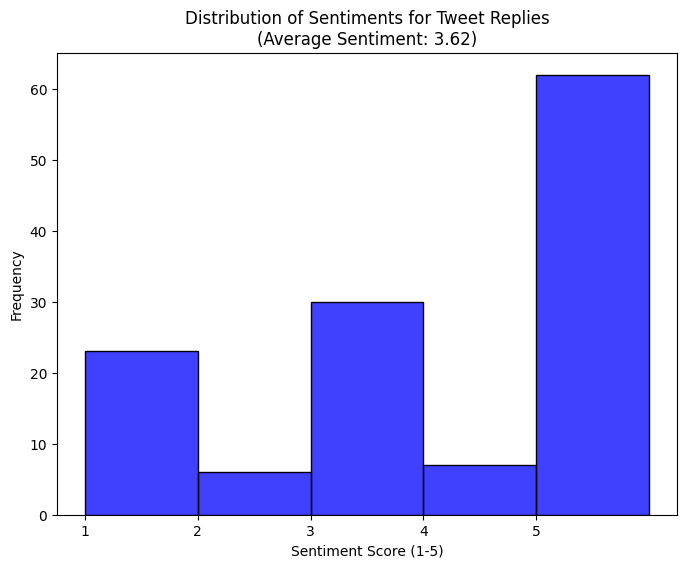

Average Sentiment Score: 3.62 (1-5 scale)


In [ ]:
import tweepy
import torch
import torch.nn as nn
import re
import numpy as np
import pandas as pd

# Set up Twitter API v2 credentials
API_KEY = 'FciOY6B2Io1iVX0LmZbpwvzRv'
API_SECRET_KEY = 'FU9GJY9rpxsYOSKjRj19OljNg36iTjr4gEzqAIgT9q2REsDcGX'
ACCESS_TOKEN = '1828993124146020352-Q0JRHTJY13QnN3jwkQC48SCZBIWExX'
ACCESS_TOKEN_SECRET = 'LHoiVK6w4DZbmTCS7w1Us3PztakuDfYeXQRhGI4EWTmHH'
BEARER_TOKEN = 'AAAAAAAAAAAAAAAAAAAAABB0vgEAAAAAIUa9l95ctGjQFAbk1Rewjq%2FmFWE%3DiId7BSE8xUxzFD73eJ6ASqk0zBcOCaIygzSb1pLNFNm9sRwvfI'

# Authenticate with Twitter API v2
client = tweepy.Client(bearer_token=BEARER_TOKEN)

# Load the trained model
model = TransformerSentimentClassifier(
    vocab_size=len(vocab),
    embed_size=64,
    num_heads=2,
    feedforward_dim=256,
    num_layers=2,
    num_classes=5,
    max_len=64
)
model.load_state_dict(torch.load('transformer_sentiment_model.pth', map_location=torch.device('cpu')))
model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Tokenizer and data preparation function
def tokenize_review(review, vocab, max_len=64):
    review = review.lower()
    review = re.sub(r'[^a-z0-9\s]', '', review)
    tokens = review.split()
    token_indices = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    if len(token_indices) < max_len:
        token_indices += [vocab['<PAD>']] * (max_len - len(token_indices))
    return token_indices[:max_len]

def predict_sentiment(review, model, vocab, device):
    token_indices = tokenize_review(review, vocab)
    input_tensor = torch.tensor([token_indices], dtype=torch.long).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        prediction = torch.argmax(output, dim=1).item()

    return prediction + 1  # Convert back to 1-5 scale

# Helper function to clean up comments
# Helper function to clean up comments
def clean_comment(comment):
    # Remove mentions (@username)
    comment = re.sub(r'@\w+', '', comment)

    # Remove URLs
    comment = re.sub(r'http\S+', '', comment)

    # Remove emojis using a more comprehensive Unicode range
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # Chinese characters
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U00002702-\U000027B0"  # Other special characters
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002600-\U000026FF"  # Miscellaneous Symbols
                               u"\U00002B50-\U00002BFF"  # Stars and other symbols
                               u"\U0001F1F2-\U0001F1F4"  # Regional Indicator Symbol Letters
                               u"\U0001F1E6-\U0001F1FF"  # flags
                               u"\U0001F201-\U0001F251"  # Enclosed characters
                               u"\U0001F004-\U0001F0CF"  # Playing cards
                               u"\U0001F018-\U0001F270"  # Additional transport & map symbols
                               "]+", flags=re.UNICODE)
    comment = emoji_pattern.sub(r'', comment)

    # Remove extra spaces
    comment = re.sub(r'\s+', ' ', comment).strip()

    # Only return if there is text remaining
    return comment if len(comment) > 0 else None

# Scrape tweet comments (replies) using Tweepy v2 API with full-archive search and English language filter
def scrape_tweet_comments(tweet_url, limit=150):
    tweet_id = tweet_url.split('/')[-1]
    query = f'conversation_id:{tweet_id} -is:retweet'

    comments = []
    paginator = tweepy.Paginator(
        client.search_recent_tweets,  # Use search_recent_tweets for recent tweets
        query=query,
        tweet_fields=['author_id', 'created_at', 'conversation_id', 'lang'],  # Fetch language field
        max_results=100  # Twitter API v2 allows up to 100 results per request
    )

    for tweet in paginator.flatten(limit=limit):
        # Filter only English-language tweets
        if tweet.lang == 'en':
            clean_text = clean_comment(tweet.text)
            if clean_text:  # Only include comments with valid text after cleaning
                comments.append(clean_text)

    return comments

# Analyze sentiment of the tweet comments and plot histogram of sentiments
def analyze_tweet_sentiment_with_histogram(tweet_url):
    comments = scrape_tweet_comments(tweet_url, limit=150)  # Adjust limit to fetch up to 150 replies
    if not comments:
        return "No comments found for the tweet."

    sentiments = []
    for comment in comments:
        # Predict the sentiment for the comment
        sentiment = predict_sentiment(comment, model, vocab, device)
        print(comment)
        print()

        # Append the predicted sentiment to the list
        sentiments.append(sentiment)
        print(sentiment)
        print()
        print()

    average_sentiment = np.mean(sentiments)

    # Plot histogram of sentiments
    plt.figure(figsize=(8, 6))
    sns.histplot(sentiments, bins=range(1, 7), kde=False, color='blue', edgecolor='black')
    plt.xticks(ticks=[1, 2, 3, 4, 5], labels=['1', '2', '3', '4', '5'])
    plt.xlabel('Sentiment Score (1-5)')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Sentiments for Tweet Replies\n(Average Sentiment: {average_sentiment:.2f})')
    plt.show()

    return average_sentiment

# Example usage
# tweet_url = "https://x.com/YouTube/status/1830802900005556252"  # Replace with the actual tweet URL
tweet_url = "https://x.com/theapplehub/status/1832844041626734749"
average_sentiment = analyze_tweet_sentiment_with_histogram(tweet_url)

print(f"Average Sentiment Score: {average_sentiment:.2f} (1-5 scale)")

## **Hyperparameter tuning**

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    embed_size = trial.suggest_categorical('embed_size', [32, 64, 128])
    num_heads = trial.suggest_categorical('num_heads', [2, 4, 8])
    feedforward_dim = trial.suggest_categorical('feedforward_dim', [128, 256])
    num_layers = trial.suggest_int('num_layers', 2, 6)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    num_epochs = trial.suggest_categorical('num_epochs', [10, 15, 20])

    # Instantiate the model with suggested hyperparameters
    model = TransformerSentimentClassifier(
        vocab_size=vocab_size,
        embed_size=embed_size,
        num_heads=num_heads,
        feedforward_dim=feedforward_dim,
        num_layers=num_layers,
        num_classes=5,
        max_len=max_len
    ).to(device)

    model.dropout = nn.Dropout(dropout_rate)  # Set dropout

    # Define loss function and optimizer
    loss_fn = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):  # Number of epochs could also be a hyperparameter
        model.train()
        for reviews, sentiments in train_loader:
            reviews, sentiments = reviews.to(device), sentiments.to(device)
            optimizer.zero_grad()
            outputs = model(reviews)
            loss = loss_fn(outputs, sentiments)
            loss.backward()
            optimizer.step()

    # Validation accuracy (you can also minimize validation loss)
    val_loss, val_accuracy = eval_model(model, val_loader, loss_fn, device)

    return val_accuracy  # We want to maximize accuracy

In [ ]:
# Create the Optuna study
study = optuna.create_study(direction='maximize')  # We want to maximize accuracy
study.optimize(objective, n_trials=50)

# Print best hyperparameters
print(f"Best hyperparameters: {study.best_params}")

# save the study for later analysis
study.trials_dataframe().to_csv("optuna_trials.csv")

[I 2024-09-03 01:19:09,101] A new study created in memory with name: no-name-84b72fd7-28a3-4871-bd47-7f23dd3727a2
<ipython-input-18-11bf0b8bec90>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
[I 2024-09-03 01:20:31,184] Trial 0 finished with value: 0.438 and parameters: {'embed_size': 128, 'num_heads': 2, 'feedforward_dim': 256, 'num_layers': 2, 'dropout_rate': 0.15728362873074597, 'learning_rate': 0.00013985507487482328, 'num_epochs': 10}. Best is trial 0 with value: 0.438.
[I 2024-09-03 01:23:40,570] Trial 1 finished with value: 0.4628 and parameters: {'embed_size': 64, 'num_heads': 2, 'feedforward_dim': 128, 'num_layers': 4, 'dropout_rate': 0.14927862057251173, 'learning_rate': 0.000562036884464347, 'num_epochs': 15}. Best is trial 1 with value: 0.4628.

Best hyperparameters: {'embed_size': 64, 'num_heads': 2, 'feedforward_dim': 256, 'num_layers': 2, 'dropout_rate': 0.2952400119787055, 'learning_rate': 0.0009777761436674669, 'num_epochs': 10}
